# Group Project - Predicting House Prices in Iowa - Team 20
How to run the workbook: We are submitting both the workbook and the dataset we used, once the dataset is saved locally the address on the next cell will have to be changed to match the new adress location.

In [68]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet

df = pd.read_csv('data.csv')



# 1-Exploration/Pre-Processing:

---



##Exploratory graphs to inform our initial hypothesis and baseline model

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Text(0, 0.5, 'Sale Price')

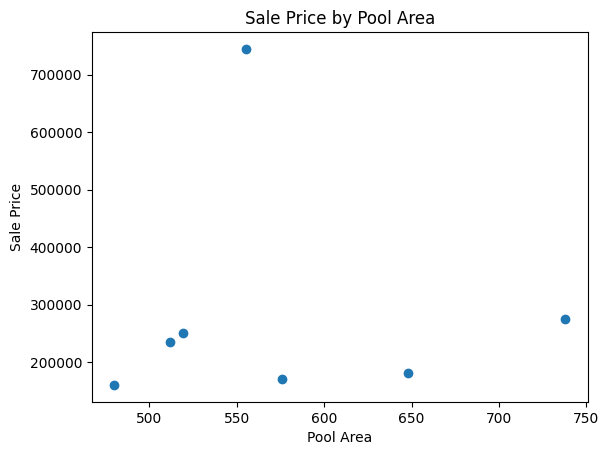

In [6]:
df2 = df[df['PoolArea']!= 0]
plt.scatter(df2['PoolArea'], df2['SalePrice'])
plt.title('Sale Price by Pool Area')
plt.xlabel('Pool Area')
plt.ylabel('Sale Price') #not enough values for this variable so we decided to drop it

Text(0, 0.5, 'SalePrice')

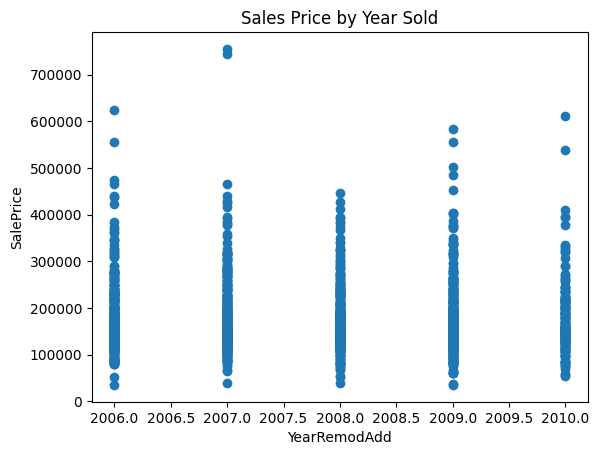

In [7]:
plt.scatter(df['YrSold'], df['SalePrice'])
plt.title('Sales Price by Year Sold')
plt.xlabel('YearRemodAdd')
plt.ylabel('SalePrice')
#there is not a discernable pattern here which is why later on, we created a new variable to capture information about age of the age

Text(0, 0.5, 'Sale Price')

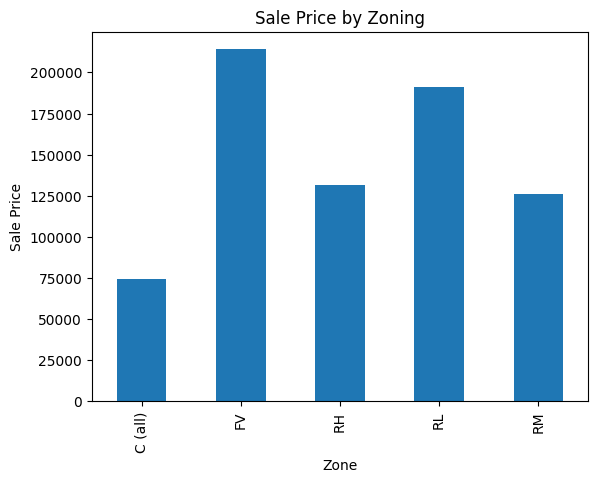

In [8]:
from pandas.core.groupby.groupby import GroupBy
df.groupby('MSZoning')['SalePrice'].mean().plot.bar()
plt.title('Sale Price by Zoning')
plt.xlabel('Zone')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

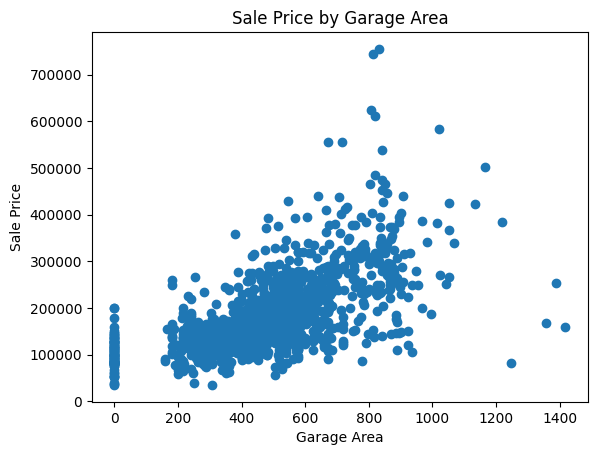

In [9]:
plt.scatter(df['GarageArea'], df['SalePrice'])
plt.title('Sale Price by Garage Area')
plt.xlabel('Garage Area')
plt.ylabel('Sale Price')

##Manually dropped columns:




In [10]:
df.drop(columns = ['Id', 'FireplaceQu', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF',
                          '2ndFlrSF', 'BsmtFinType1','BsmtFinType2', 'LowQualFinSF', 'MSSubClass',
                          'ExterQual', 'ExterCond', 'MasVnrArea', 'YearBuilt',
                          'Neighborhood','MSSubClass', 'LandSlope', 'LotShape','BldgType','Functional',
                   'SaleType','MiscFeature','MiscVal','GarageCars','MoSold','PoolArea'] , axis = 1, inplace = True)

##Replaced 0 values with NaN for predictors in which a 0 value was clearly an error:

In [11]:
df[['BsmtQual','BsmtCond','BsmtExposure','GarageQual','GarageCond']] = df[['BsmtQual','BsmtCond','BsmtExposure',
                                                                           'GarageQual','GarageCond']].replace(np.NaN,0)

##Transformed variables with string rankings to numerical rankings

In [12]:
df[['BsmtQual','BsmtCond','KitchenQual','HeatingQC','GarageQual','GarageCond']] = df[['BsmtQual','BsmtCond',
                                                                                      'KitchenQual','HeatingQC',
                                                                                      'GarageQual','GarageCond']].replace("Ex",5).replace("Gd",4).replace("TA",3).replace("Fa",2).replace("Po",1)

In [13]:
df['BsmtExposure'] = df['BsmtExposure'].replace("Gd",4).replace("Av",3).replace("Mn",2).replace("No",1)

##Dropped columns with too many NaN values (at least 20%):




In [14]:
df.dropna(axis=1, thresh=0.2*1460, inplace=True)

## Created to list with the column names for our categorical and numerical predictors





In [15]:
categorical_predictors = df.select_dtypes(include=['object']).columns  #return a list of all the columns where the datatype is 'object'
numerical_predictors = df.select_dtypes(include=['int64','float64','uint8']).columns.drop('SalePrice')

##One hot encoded our categorical variables:

In [16]:
df = pd.get_dummies(df, columns=categorical_predictors, drop_first=True)

## Combining variables that capture same information about different iterations of the same feature

In [17]:
#Adding both Exterior columns together:
df['Exterior_AsphShn'] = df['Exterior1st_AsphShn'] + df['Exterior2nd_AsphShn']
df = df.drop(columns=['Exterior1st_AsphShn','Exterior2nd_AsphShn'])

df['Exterior_BrkComm'] = df['Exterior1st_BrkComm'] + df['Exterior2nd_Brk Cmn']
df = df.drop(columns=['Exterior1st_BrkComm','Exterior2nd_Brk Cmn'])

df['Exterior_BrkFace'] = df['Exterior1st_BrkFace']+df['Exterior2nd_BrkFace']
df = df.drop(columns=['Exterior1st_BrkFace','Exterior2nd_BrkFace'])

df['Exterior_CBlock'] = df['Exterior1st_CBlock'] + df['Exterior2nd_CBlock']
df = df.drop(columns=['Exterior1st_CBlock','Exterior2nd_CBlock'])

df['Exterior_CemntBd'] = df['Exterior1st_CemntBd'] + df['Exterior2nd_CmentBd']
df = df.drop(columns=['Exterior1st_CemntBd','Exterior2nd_CmentBd'])

df['Exterior_HdBoard'] = df['Exterior1st_HdBoard'] + df['Exterior2nd_HdBoard']
df = df.drop(columns=['Exterior1st_HdBoard', 'Exterior2nd_HdBoard'])

df['Exterior_ImStucc'] = df['Exterior1st_ImStucc'] + df['Exterior2nd_ImStucc']
df = df.drop(columns=['Exterior1st_ImStucc','Exterior2nd_ImStucc'])

df['Exterior_MetalSd'] = df['Exterior1st_MetalSd'] + df['Exterior2nd_MetalSd']
df = df.drop(columns=['Exterior1st_MetalSd', 'Exterior2nd_MetalSd'])

df['Exterior_Plywood'] = df['Exterior1st_Plywood'] + df['Exterior2nd_Plywood']
df = df.drop(columns=['Exterior1st_Plywood','Exterior2nd_Plywood'])

df['Exterior_Stone'] = df['Exterior1st_Stone'] + df['Exterior2nd_Stone']
df = df.drop(columns=['Exterior1st_Stone','Exterior2nd_Stone'])

df['Exterior_Stucco'] = df['Exterior1st_Stucco'] + df['Exterior2nd_Stucco']
df = df.drop(columns=['Exterior1st_Stucco','Exterior2nd_Stucco'])

df['Exterior_VinylSd'] = df['Exterior1st_VinylSd'] + df['Exterior2nd_VinylSd']
df = df.drop(columns=['Exterior1st_VinylSd','Exterior2nd_VinylSd'])

df['Exterior_Wd_Sdng'] = df['Exterior1st_Wd Sdng'] + df['Exterior2nd_Wd Sdng']
df = df.drop(columns=['Exterior1st_Wd Sdng','Exterior2nd_Wd Sdng'])

df['Exterior_WdShing'] = df['Exterior1st_WdShing'] + df['Exterior2nd_Wd Shng']
df = df.drop(columns=['Exterior1st_WdShing','Exterior2nd_Wd Shng'])

In [18]:
#Adding both Lot Condition columns together:
df['Condition_Feedr'] = df['Condition1_Feedr'] + df['Condition2_Feedr']
df = df.drop(columns=['Condition1_Feedr','Condition2_Feedr'])

df['Condition_Norm'] = df['Condition1_Norm'] + df['Condition2_Norm']
df = df.drop(columns=['Condition1_Norm','Condition2_Norm'])

df['Condition_PosA'] = df['Condition1_PosA'] + df['Condition2_PosA']
df = df.drop(columns=['Condition1_PosA','Condition2_PosA'])

df['Condition_PosN'] = df['Condition1_PosN'] + df['Condition2_PosN']
df = df.drop(columns=['Condition1_PosN','Condition2_PosN'])

df['Condition_RRAe'] = df['Condition1_RRAe'] + df['Condition2_RRAe']
df = df.drop(columns=['Condition1_RRAe','Condition2_RRAe'])

df['Condition_RRAn'] = df['Condition1_RRAn'] + df['Condition2_RRAn']
df = df.drop(columns=['Condition1_RRAn','Condition2_RRAn'])

df['Condition_RRNe'] = df['Condition1_RRNe']
df = df.drop(columns=['Condition1_RRNe'])

df['Condition_RRNn'] = df['Condition1_RRNn'] + df['Condition2_RRNn']
df = df.drop(columns=['Condition1_RRNn','Condition2_RRNn'])

##Transformed the YearRemodAdd into a new predictor that captures the years since the house was last remodeled from the year of the sale

Text(0, 0.5, 'SalePrice')

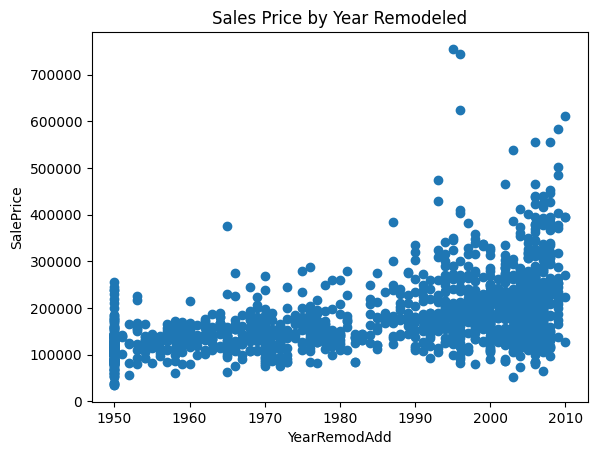

In [19]:
plt.scatter(df['YearRemodAdd'], df['SalePrice'])
plt.title('Sales Price by Year Remodeled')
plt.xlabel('YearRemodAdd')
plt.ylabel('SalePrice')

In [20]:
df['years_since_remod'] = df['YrSold'] - df['YearRemodAdd']

Text(0, 0.5, 'SalePrice')

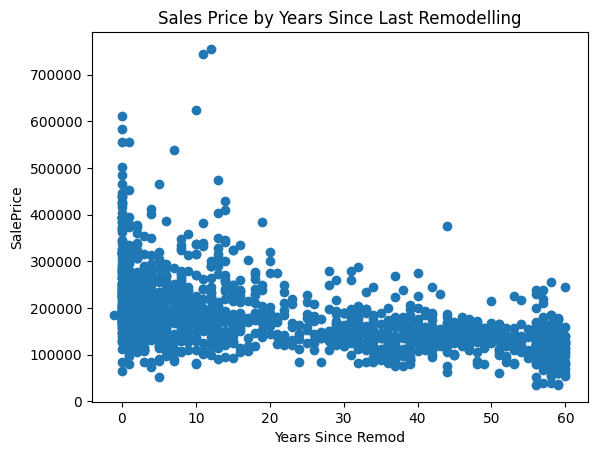

In [21]:
plt.scatter(df['years_since_remod'], df['SalePrice'])
plt.title('Sales Price by Years Since Last Remodelling')
plt.xlabel('Years Since Remod')
plt.ylabel('SalePrice')

In [22]:
df.drop(columns='YearRemodAdd', axis=1, inplace=True) #Dropping the old column
numerical_predictors = numerical_predictors.drop('YearRemodAdd') #Updating the numerical predictors
numerical_predictors = numerical_predictors.append(df[['years_since_remod']].columns)

##Updated our categorical varible list with the new dummies:

In [23]:
categorical_predictors = df.drop(columns=numerical_predictors).columns

##Imputation Methods (might take between 2-3 min to run)

###Comparing Different Imputation Methods

In [24]:
#Function to display before and after graphs
def compare_dataframes(df_original, df_imputed):

  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

  axs[0].scatter(df_original['GarageArea'], df_original['SalePrice'],s=15)
  axs[0].set_title('Original')
  axs[0].set_xlabel('GarageArea')
  axs[0].set_ylabel('SalePrice')


  axs[1].scatter(df_imputed['GarageArea'], df_imputed['SalePrice'],s=15)
  axs[1].set_title('With Imputation')

  axs[1].set_xlabel('GarageArea')
  axs[1].set_ylabel('SalePrice')
  plt.show();
  return

In [25]:
#Create a copy of our original dataset
df_original = df.copy().iloc[:600]

#Drop any missing values
df_original.dropna(inplace = True)

#Keep only columns for testing
df_original = df_original[['SalePrice', 'GarageArea']]

In [26]:
#Create a copy but artificially replacing some values with NaN
df_w_null = df_original.copy(deep = True)

df_w_null.loc[:300, 'SalePrice'] = np.NaN
df_w_null.loc[:150, 'GarageArea'] = np.NaN

####Imputation With The Mean:

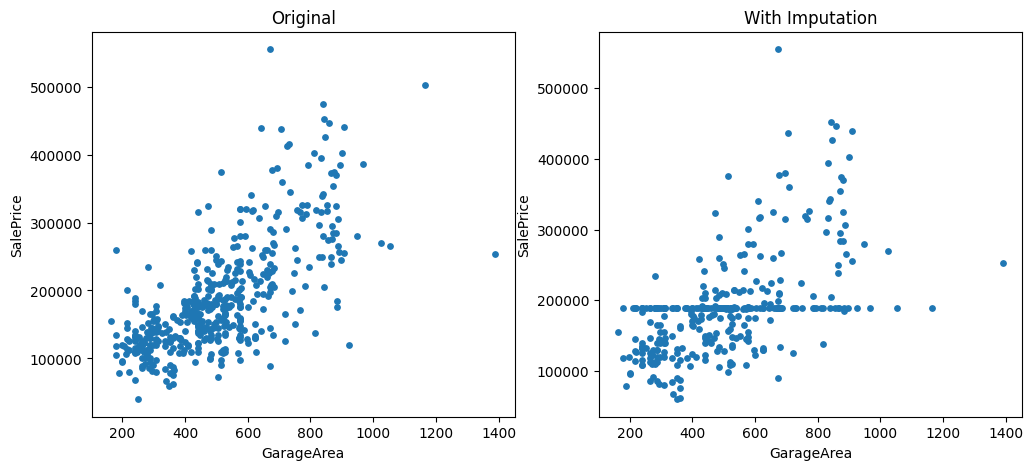

In [27]:
df_fill_mean = df_w_null.copy(deep = True)
df_fill_mean['SalePrice'] = df_fill_mean['SalePrice'].fillna(np.mean(df_fill_mean['SalePrice']))
df_fill_mean['GarageArea'] = df_fill_mean['GarageArea'].fillna(np.mean(df_fill_mean['GarageArea']))
compare_dataframes(df_original, df_fill_mean)

####Imputation With MICE:

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


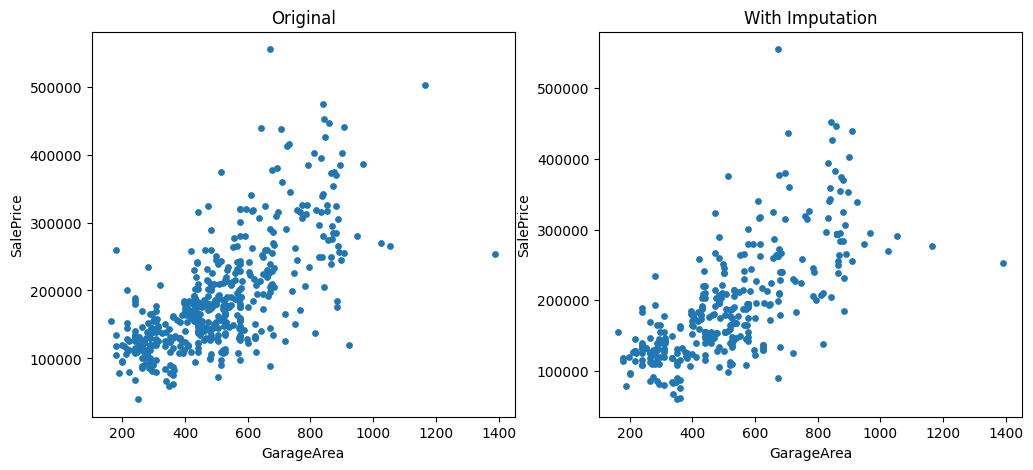

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='mean',
                               max_iter=50, random_state=0)
imp_num.fit(df_w_null)
df_imputer = pd.DataFrame(imp_num.transform(df_w_null), columns = df_w_null.columns)
compare_dataframes(df_original, df_imputer)

###Using MICE on our Dataset:

In [29]:
imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='mean',
                               max_iter=100, random_state=1)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(),
                               initial_strategy='most_frequent',
                               max_iter=100, random_state=1)

df[numerical_predictors] = imp_num.fit_transform(df[numerical_predictors])
df[categorical_predictors] = imp_cat.fit_transform(df[categorical_predictors])

##Combining columns now that there are no NaN values left:

In [30]:
df['Total_Full_Bath'] = df['BsmtFullBath'] + df['FullBath']
df['Total_Half_Bath'] = df['BsmtHalfBath'] + df['HalfBath']
df['Total_SF'] = df['TotalBsmtSF'] + df['GrLivArea']

drop_columns = ['BsmtFullBath', 'FullBath', 'BsmtHalfBath',
                   'HalfBath', 'TotalBsmtSF', 'GrLivArea' ]

df.drop(columns = drop_columns, inplace=True)
numerical_predictors = numerical_predictors.drop(drop_columns)
numerical_predictors = numerical_predictors.append(df[['Total_SF','Total_Full_Bath', 'Total_Half_Bath']].columns)

##Fixing outliers for more exploratory graphs

Text(0, 0.5, 'Sale Price')

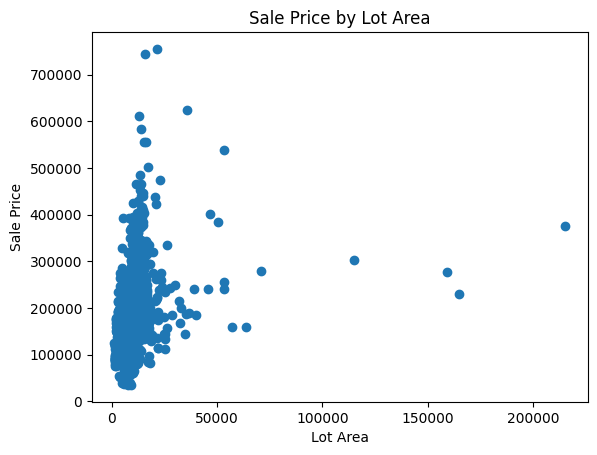

In [31]:
plt.scatter(df['LotArea'], df['SalePrice'])
plt.title('Sale Price by Lot Area')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

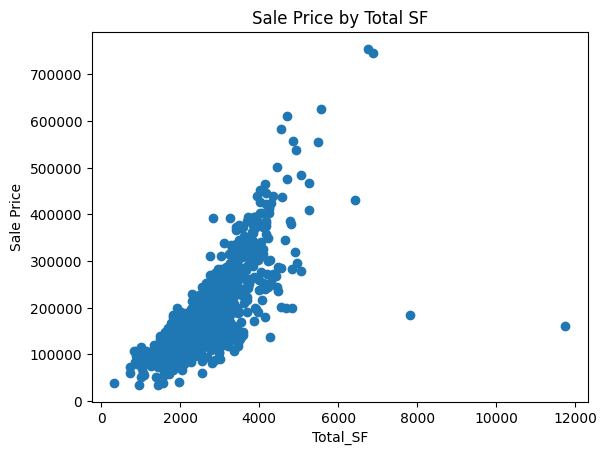

In [32]:
plt.scatter(df['Total_SF'], df['SalePrice'])
plt.title('Sale Price by Total SF')
plt.xlabel('Total_SF')
plt.ylabel('Sale Price')

In [33]:
#Defining IQR and Upper/Lower bounds for Total_Sf
df_quartile_25 = np.percentile(df['Total_SF'], 25, interpolation = 'midpoint')
df_quartile_75 = np.percentile(df['Total_SF'], 75, interpolation = 'midpoint')

df_iqr =  df_quartile_75 - df_quartile_25

df_bottom_bound = df_quartile_25 - 1.5 * df_iqr
df_top_bound = df_quartile_75 + 1.5 * df_iqr
print(df_bottom_bound, df_top_bound)

521.5 4501.5


<ipython-input-33-df0f174bba53>:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  df_quartile_25 = np.percentile(df['Total_SF'], 25, interpolation = 'midpoint')
<ipython-input-33-df0f174bba53>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  df_quartile_75 = np.percentile(df['Total_SF'], 75, interpolation = 'midpoint')


In [34]:
df = df[df.Total_SF>df_bottom_bound]
df = df[df.Total_SF<df_top_bound]

Text(0, 0.5, 'Sale Price')

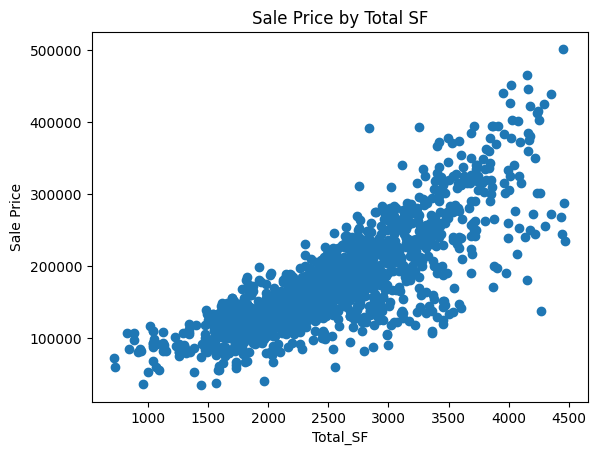

In [35]:
plt.scatter(df['Total_SF'], df['SalePrice'])
plt.title('Sale Price by Total SF')
plt.xlabel('Total_SF')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

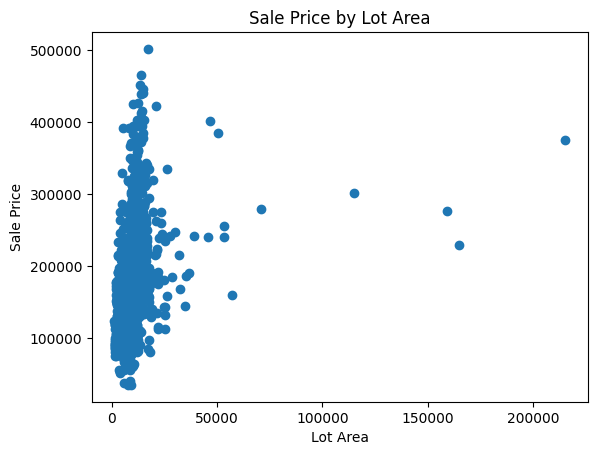

In [36]:
#There are still Outliers in LotArea
plt.scatter(df['LotArea'], df['SalePrice'])
plt.title('Sale Price by Lot Area')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

In [37]:
#Defining IQR and Upper/Lower bounds for LotArea
df_quartile_25 = np.percentile(df['LotArea'], 25)
df_quartile_75 = np.percentile(df['LotArea'], 75)

df_iqr =  df_quartile_75 - df_quartile_25

df_bottom_bound = df_quartile_25 - 1.5 * df_iqr
df_top_bound = df_quartile_75 + 1.5 * df_iqr
print(df_bottom_bound, df_top_bound)

1594.5 17342.5


In [38]:
df = df[df.LotArea>df_bottom_bound]
df = df[df.LotArea<df_top_bound]

Text(0, 0.5, 'Sale Price')

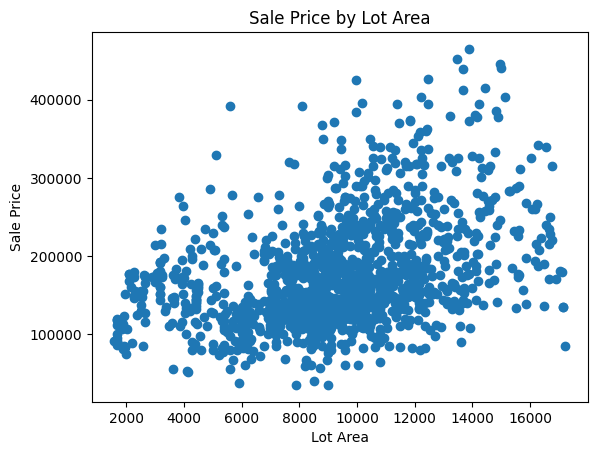

In [39]:
plt.scatter(df['LotArea'], df['SalePrice'])
plt.title('Sale Price by Lot Area')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

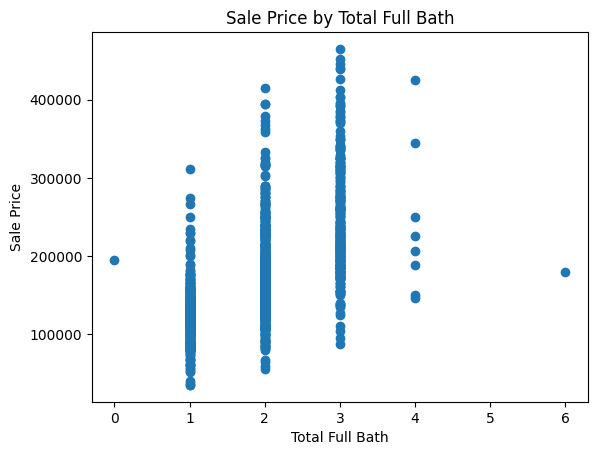

In [40]:
plt.scatter(df['Total_Full_Bath'], df['SalePrice'])
plt.title('Sale Price by Total Full Bath')
plt.xlabel('Total Full Bath')
plt.ylabel('Sale Price')

In [41]:
df = df.drop(df['Total_Full_Bath'].idxmin())#Dropped outliers

Text(0, 0.5, 'Sale Price')

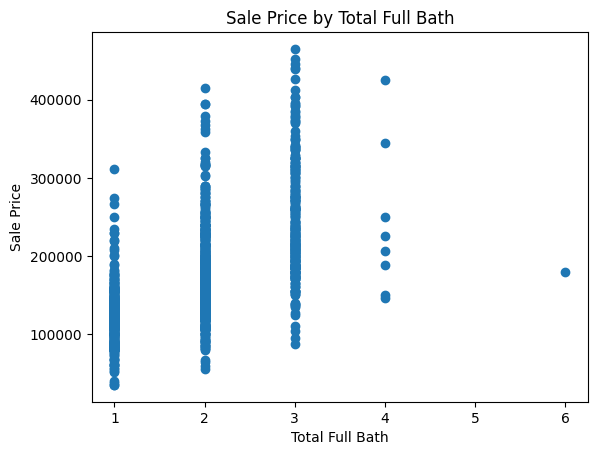

In [42]:
plt.scatter(df['Total_Full_Bath'], df['SalePrice'])
plt.title('Sale Price by Total Full Bath')
plt.xlabel('Total Full Bath')
plt.ylabel('Sale Price')

#2-Baseline Model:

---

For the baseline model we added predictors that seemed important after our exploratory analysis

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#We manually picked the predictors we belived to be important in predicting the Sale Price
base_predictors = ['Total_SF','Total_Half_Bath','Total_Full_Bath','years_since_remod',
                   'MSZoning_FV','MSZoning_RH','MSZoning_RL','MSZoning_RM',
                   'OverallCond','GarageArea','LotArea','HouseStyle_1.5Unf',
                   'HouseStyle_1Story','HouseStyle_2.5Fin','HouseStyle_2.5Unf',
                   'HouseStyle_2Story','HouseStyle_SFoyer','HouseStyle_SLvl',
                   'Foundation_CBlock','Foundation_PConc','Foundation_Slab',
                   'Foundation_Stone','Foundation_Wood','WoodDeckSF',
                   'Fireplaces','Heating_GasA','Heating_GasW','Heating_Grav',
                   'Heating_OthW','Heating_Wall','CentralAir_Y']

X = df[base_predictors]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 1)
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_test_fit = model.predict(X_test)                # 4b. predict on test data
mse_test = np.mean( (y_test - y_test_fit)**2 )
print('RMSE: ' + str(np.sqrt(mse_test)) + '\nMSE: ' + str(mse_test))
#Maybe we can check t-stat for these base predictors and already drop some of the worst ones?
#There is also an F-score to check significant of multiple predictors(I think), we could use that to check our binary predictors

RMSE: 27023.75933363336
MSE: 730283568.5221361


#3-PCA/Feature Selection:

---



##PCA:

---

According to the cumulative proportion, we need 55 components to capture only 80% of the variation. This is likely due to the fact that we have many categorical predictors in our full dataset. So we decided to choose another method to shrink our number of predictors

In [44]:
# PCA
pca = PCA()
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca)])
X_for_PCA = df.drop(columns='SalePrice')

pipe.fit(X_for_PCA)


# view the importance of principal components
pcsSummary_df = pd.DataFrame({
           'Proportion of variance': pipe['pca'].explained_variance_ratio_,
          'Cumulative proportion': np.cumsum(pipe['pca'].explained_variance_ratio_)
          })
pcsSummary_df.transpose().round(3)

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
Proportion of variance,0.094,0.037,0.033,0.027,0.023,0.023,0.020,0.020,0.018,0.018,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cumulative proportion,0.094,0.131,0.164,0.191,0.214,0.237,0.257,0.277,0.295,0.313,...,0.999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
#Eigenvalues per Component:
eig=pipe['pca'].explained_variance_.round(2)
pd.DataFrame(eig)

,0
0,10.57
1,4.14
2,3.67
3,3.04
4,2.59
...,...
110,0.00
111,0.00
112,0.00
113,0.00


In [ ]:
# scree plot of eigenvalues
xvals = np.arange(0,115,step=1);
#figure size
plt.figure(figsize=(30,20))
#plot in red color
plt.plot(xvals, eig, 'ro-', linewidth=1)
#set ticks to every unit
plt.xticks(xvals)

#add labels
plt.title('Eigenvalue for each Component')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.ylim(0,)
plt.xlim(0,)


#add a horizontal line in blue
plt.axhline(y=1, color='b', linestyle='--');

##Forward Selection: (might take 2-3min to run)

Train/Test Split:

In [ ]:
#Train, Test Split:
#Old split only have our manually selected varibles
X = df.drop(columns='SalePrice')
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 1)

In [ ]:
#Creating the sequential selector
selection_model = SequentialFeatureSelector(LinearRegression(), n_features_to_select=0.2)
selection_model.fit(X_train, y_train)
selected_columns = X_train.columns[selection_model.get_support()]

In [ ]:
#Updating train and test sets so that they only included selected features:
df_clean = pd.concat([df[selected_columns], df['SalePrice']], axis=1)
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [ ]:
#Find the categorical predictors selected by forward selection
df_clean.columns

#4-Models:

---



##Decision Tree:

Parameter Tuned: Maximum leaf nodes

In [ ]:
max_leafs = [2,3,4,5,6,7,8,9,10,11,12]
mse_scores = []

for value in max_leafs:
  dt = DecisionTreeRegressor(max_leaf_nodes=value, random_state=1)

  current_mse_score = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
  mse_scores.append([-1*current_mse_score,value]) #Needs to be multiplied by -1 since we calculated negative mse

best_leaf_nodes = min(mse_scores)[1]
print('Best leafs ' + str(best_leaf_nodes))

In [ ]:
#Pruned Tree:
dt_prunned = DecisionTreeRegressor(max_leaf_nodes=best_leaf_nodes, random_state=0)
dt_prunned.fit(X_train, y_train)

yhat_prunned = dt_prunned.predict(X_test)
mse_prunned = np.mean(mean_squared_error(y_test, yhat_prunned))
print('RMSE Tuned: ' + str(np.sqrt(mse_prunned)))

In [ ]:
plt.figure(figsize=(20,15))
tree.plot_tree(dt_prunned, filled=False, fontsize=8, feature_names=X_train.columns);

##Random Forest:

In [ ]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train, y_train)

rf_mse = mean_squared_error(y_test, rf.predict(X_test))
print('Random Forest MSE: ' + str(np.sqrt(rf_mse)))

##KNN

In [ ]:
knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2))
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred), 'RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

Parameters Tuned: K, weights

In [ ]:
pipe = Pipeline([('scaler',StandardScaler()), ('knn',KNeighborsRegressor())])
parameters = {'knn__n_neighbors':[1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'knn__weights':['uniform', 'distance']
              }

knn_tuned = GridSearchCV(pipe, param_grid=parameters,
                        scoring='neg_mean_squared_error', cv=5, n_jobs=-1
                        )

knn_tuned.fit(X_train, y_train)
knn_tuned.best_params_

In [ ]:
#To create the graph of RMSE by K value:
results = []
for k in range(1, 20, 1):

    knn = KNeighborsRegressor(n_neighbors=k, weights=knn_tuned.best_params_['knn__weights'])
    knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring= 'neg_mean_squared_error')
    knn_mse = -np.mean(knn_cv_scores)


    results.append([
       np.sqrt(knn_mse).round(), k
    ])
    results_df = pd.DataFrame(results, columns=['RMSE', 'K'])

results_df.plot.scatter(x='K', y='RMSE', xlim=[0,20])
plt.title('Model RMSE with different K values')


In [ ]:
#Tuned KNN
knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=knn_tuned.best_params_['knn__n_neighbors'], weights=knn_tuned.best_params_['knn__weights']))
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('MSE Tuned: ', mean_squared_error(y_test, y_pred), 'RMSE Tuned: ', np.sqrt(mean_squared_error(y_test, y_pred)))

##Regularized Regression: Lasso

The sklearn algorithm for Lasso does not work well with alpha=0. To create a baseline before tuning we used a normal linear regression since that would be the same as running Lasso with alpha = 0

In [ ]:
#Linear Regression
linear = LinearRegression()
linear.fit(X_train, y_train)
y_test_fit_linear = linear.predict(X_test)
base_mse = mean_squared_error(y_test, y_test_fit_linear)
print(np.sqrt(base_mse), base_mse)

In [60]:
#Tuning lambda
num_lambdas = 10
lambdas = np.array([1e-5,1e-4,1e-3, 1e-2, 1, 10])
y_train_hat = np.zeros((y_train.shape[0], num_lambdas))
y_test_hat = np.zeros((y_test.shape[0], num_lambdas))
coefficients = np.zeros((X_train.shape[1], num_lambdas))

In [61]:
for i, current_lambda in enumerate(lambdas):
     pipe = make_pipeline(StandardScaler(),
                      Lasso(alpha=current_lambda, random_state=0))
     pipe.fit(X_train, y_train)

     #predictions on the training and testing sets
     y_test_hat_fit_lasso = pipe.predict(X_test)
     y_train_hat_fit_lasso = pipe.predict(X_train)

     y_train_hat[ : ,i]= y_train_hat_fit_lasso
     y_test_hat[ : ,i]= y_test_hat_fit_lasso
     coefficients[ : ,i] = pipe[-1].coef_

In [62]:
mse_train = []
mse_test = []

for i in range(num_lambdas):
  mse_train.append(mean_squared_error(y_train, y_train_hat[:,i]))
  mse_test.append(mean_squared_error(y_test, y_test_hat[:,i]))

print(mse_train)
print(mse_test)

[498400822.6946944, 498400822.69469464, 498400822.6947232, 498400822.69749504, 498400851.2482942, 498403606.36716396, 35446814064.75459, 35446814064.75459, 35446814064.75459, 35446814064.75459]
[472050550.1262986, 472050548.66821694, 472050532.8466771, 472050372.4012117, 472033150.672405, 471876279.3649975, 34663619395.60073, 34663619395.60073, 34663619395.60073, 34663619395.60073]


In [63]:
#Finding the best lambda
lowest_mse = min(mse_train)
lambda_index = mse_train.index(lowest_mse)
best_lambda = lambdas[lambda_index]
print('Best_lambda: ', lambdas[lambda_index])

Best_lambda:  1e-05


In [64]:
lasso_tuned = Lasso(alpha=best_lambda)
lasso_tuned_cv_scores = cross_val_score(lasso_tuned, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#lasso_tuned.fit(X_train, y_train)
#y_test_fit_lasso = lasso_tuned.predict(X_test)
#lowest_mse_test = mean_squared_error(y_test, y_test_fit_lasso)
lowest_mse = -np.mean(lasso_tuned_cv_scores)
print('RMSE Tuned: ', np.sqrt(lowest_mse), '\nMSE Tuned: ', lowest_mse)

RMSE Tuned:  23026.00723084386 
MSE Tuned:  530197008.9948738


In [65]:
print('Baseline RMSE:', np.sqrt(base_mse).round(5))
print('Tuned RMSE:', np.sqrt(lowest_mse).round(5))

print('Total % Change in RMSE:', (base_mse-(lowest_mse))/base_mse)

Baseline RMSE: 21726.72433
Tuned RMSE: 23026.00723
Total % Change in RMSE: -0.12317845758698288


##Elastic Net:

In [66]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(l1_ratio=0.99) #alpha = 1 default
elastic_net.fit(X_train, y_train)
y_test_fit_elastic = elastic_net.predict(X_test)
elastic_mse = mean_squared_error(y_test, y_test_fit_elastic)
print('RMSE: ' + str(np.sqrt(elastic_mse)) + '\nMSE: ' + str(elastic_mse))

RMSE: 21597.838359813435
MSE: 466466621.81662875


In [67]:
print('Tuned Lasso RMSE:', np.sqrt(lowest_mse).round(5))
print('Tuned Elastic Net RMSE:', np.sqrt(elastic_mse).round(5))

print('Total % Change in RMSE:', ((lowest_mse-(elastic_mse))/lowest_mse).round(3))

Tuned Lasso RMSE: 23026.00723
Tuned Elastic Net RMSE: 21597.83836
Total % Change in RMSE: 0.12
